In [1]:
from ica_benchmark.scoring import mutual_information, coherence, correntropy, apply_pairwise, apply_pairwise_parallel, SCORING_FN_DICT
from ica_benchmark.processing.ica import get_ica_transformers
import time
from ica_benchmark.io.load import join_gdfs_to_numpy, load_subjects_data, load_subject_data
from ica_benchmark.processing.label import get_annotations
from mne import find_events, events_from_annotations
from mne.viz import plot_events

In [2]:
from mne.io import read_raw_gdf

gdf = read_raw_gdf("C:\\Users\\paull\\Documents\\GIT\\BCI_MsC\\notebooks\\BCI_Comp_IV_2a\\BCICIV_2a_gdf\\A01E.gdf", preload=True)
events = events_from_annotations(gdf)

In [4]:
#plot_events(events[0], sfreq=gdf.info['sfreq'], first_samp=gdf.first_samp, event_id=events[1])

In [5]:
# import matplotlib.pyplot as plt
# %matplotlib notebook
# gdf.plot()

In [6]:
from pathlib import Path

root = Path("C:/Users/paull/Documents/GIT/BCI_MsC/notebooks/BCI_Comp_IV_2a/BCICIV_2a_gdf")

subjects =  {
    "A01": [
        "C:\\Users\\paull\\Documents\\GIT\\BCI_MsC\\notebooks\\BCI_Comp_IV_2a\\BCICIV_2a_gdf\\A01E.gdf",
        "C:\\Users\\paull\\Documents\\GIT\\BCI_MsC\\notebooks\\BCI_Comp_IV_2a\\BCICIV_2a_gdf\\A01T.gdf"
    ]
}


In [7]:
data = load_subjects_data(root, subjects)

In [8]:
arr = data["A01"]["gdf"]._data.T
labels = data["A01"]["labels"]
arr.shape, labels.shape

((1359528, 22), (1359528, 11))

In [9]:
arr = arr.transpose(1, 0).reshape(1, 22, -1)
arr = arr[:, :, 785241 - 3000:785552 + 3000]
arr.shape

(1, 22, 6311)

In [130]:
from mne.time_frequency import psd_multitaper, tfr_array_multitaper, psd_array_multitaper
import numpy as np
import matplotlib.pyplot as plt
from ica_benchmark.processing.ica import create_gdf_obj

In [11]:
res = tfr_array_multitaper(arr, 250, np.linspace(1, 12, 100), output="power", n_cycles=3, decim=10)
res = res.squeeze()

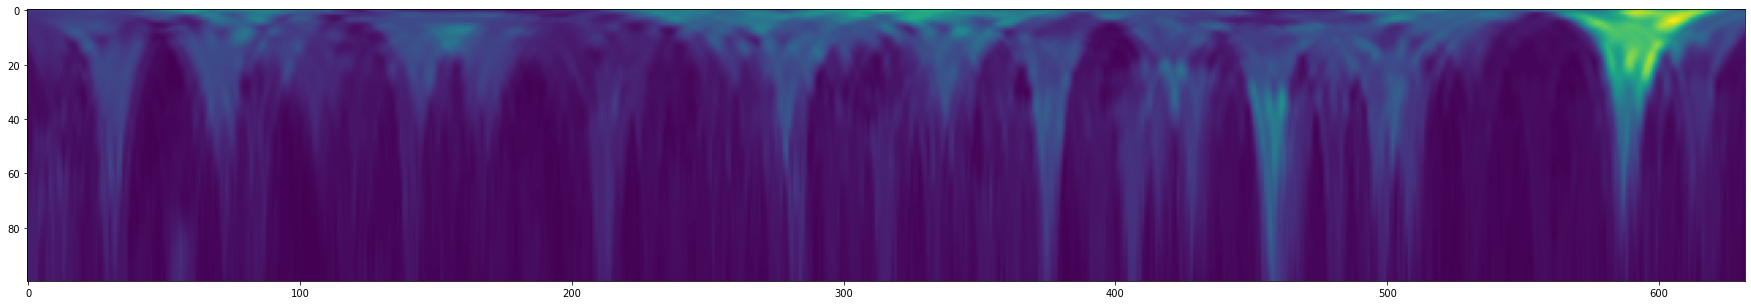

In [12]:
plt.figure(figsize=(100, 5))
plt.imshow(res[0, :, :])
plt.savefig("fig.png")

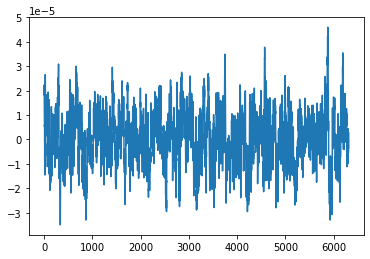

In [14]:
plt.plot(arr[0, 0, :])

In [126]:
from torch.utils.data import IterableDataset, DataLoader
import torch

DEFAULT_FREQUENCIES = np.linspace(1, 30, 30)

def tfr_multitaper(
    arr, 
    sfreq=250.0,
    freqs=DEFAULT_FREQUENCIES, 
    n_cycles=7.0,
    zero_mean=True,
    time_bandwidth=4,
#     use_fft=True,
    decim=1,
    output='power',
    n_jobs=1,
    feature_format=True
):
    arr = np.expand_dims(arr.T, axis=0)
    trf_psd = tfr_array_multitaper(
        arr,
        sfreq=sfreq,
        freqs=freqs,
        time_bandwidth=time_bandwidth,
        output=output,
        n_cycles=n_cycles,
        decim=decim,
        n_jobs=n_jobs,
    )
    if feature_format is None:
        return tfr_psd
    
    if feature_format:
        #(n_times, n_channels, n_freqs, size) -> (size, features)
        size = trf_psd.shape[3]
        trf_psd = trf_psd.squeeze().transpose(2, 1, 0).reshape(size, -1)
    else:
        trf_psd = trf_psd.squeeze().transpose(2, 0, 1)
    return trf_psd

def tfr_epochs_multitaper(
    arr, 
    sfreq=250.0,
    freqs=DEFAULT_FREQUENCIES, 
    n_cycles=7.0,
    zero_mean=True,
    time_bandwidth=4,
#     use_fft=True,
    decim=1,
    output='power',
    n_jobs=1,
    feature_format=True,
    window_size=250,
    stride=250, 
    agg_fn=None
):
    
#     new_arr = None
#     for i in range(0, len(arr), stride):
#         if i + window_size > len(arr):
#             break
#         item = np.expand_dims(arr[i : i + window_size].T, axis=0)
#         if new_arr is None:
#             new_arr = item
#         else:
#             new_arr = np.concatenate([new_arr, item], axis=0)
    new_arr = []
    for i in range(0, len(arr), stride):
        if i + window_size > len(arr):
            break
        item = np.expand_dims(arr[i : i + window_size].T, axis=0)
        new_arr.append(item)
    new_arr = np.concatenate(new_arr, axis=0)

    trf_psd = tfr_array_multitaper(
        new_arr,
        sfreq=sfreq,
        freqs=freqs,
        time_bandwidth=time_bandwidth,
        output=output,
        n_cycles=n_cycles,
        decim=decim,
        n_jobs=n_jobs,
    )

    if feature_format is None:
        return trf_psd
    
    if feature_format:
        size = trf_psd.shape[0]
        trf_psd = trf_psd.mean(axis=3).reshape(size, -1)
    else:
        trf_psd = trf_psd.transpose(0, 1, 3, 2)
    return trf_psd

def window_gen(
    arr,
    start=None,
    end=None,
    window_size=250,
    stride=125,
    cut_end=True,
    agg_fn=None
):
    size = len(arr)
    if start is None:
        start = 0
    if end is None:
        end = size
    n_steps = size 
    for i in range(start, end - window_size, stride):
        item = arr[i : i + window_size]
        if agg_fn is not None:
            item = agg_fn(item)
        yield item

class TFRDataset(IterableDataset):
    def __init__(self, arr, start=None, end=None, window_size=250, stride=125):
        super(TFRDataset).__init__()
        
        if start is None:
            start = 0
        if end is None:
            end = len(arr)
        
        assert end > start, "this example code only works with end >= start"

        self.start = start
        self.end = end
        self.arr = arr
        self.labels = labels
        self.window_size = window_size
        self.stride = stride

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(np.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        feature_iter = window_gen(
            self.arr,
            start = iter_start,
            end = iter_end,
            window_size = self.window_size,
            stride = self.stride
        )
        
        return feature_iter

In [129]:
arr = np.random.rand(30000, 5)
# trf = tfr_multitaper(arr, feature_format=False)
# for x in window_gen(trf):
# for x in TFRDataset(trf):
#     print(type(x))

a = tfr_epochs_multitaper(arr, feature_format=False, window_size=1000, stride=750, n_cycles=3, n_jobs=3).shape
# b = tfr_epochs_multitaper(arr, feature_format=None, window_size=1000, n_cycles=3, output="avg_power", n_jobs=3).shape

print(a)


(39, 5, 1000, 30)


In [153]:
a = np.sin(np.linspace(-10, 10, 1000)).reshape(1, -1) + np.sin(5 * np.linspace(-10, 10, 1000)).reshape(1, -1) + np.sin(15 * np.linspace(-10, 10, 1000)).reshape(1, -1)
psd, freqs = psd_array_multitaper(a, sfreq=250, fmax=30)
# psd.shape

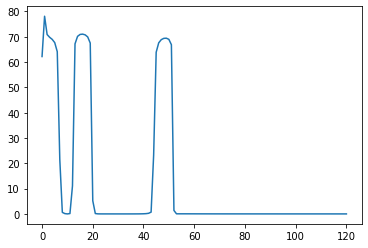

In [154]:
plt.plot(psd[0, :])

In [139]:
freqs

array([0.00000000e+00, 8.33333333e-03, 1.66666667e-02, ...,
       1.24983333e+02, 1.24991667e+02, 1.25000000e+02])